# ДЗ3 на основе базового решения задачи "Разработка нефтегазовых месторождений"

Набор данных содержит 442 о различных нефтегазовых месторождениях.
Тренировочный набор - 309 строк.
Тестовый набор - 133 строк.

Каждое месторождение обладает 19 параметрами:
1. Field name - название месторождения
2. Reservoir unit - юнит месторождения
3. Country - страна расположения
4. Region - регион расположения
5. Basin name - название бассейна пород
6. Tectonic regime - тектонический режим
7. Latitude - широта
8. Longitude - долгота
9. Operator company - название компании
10. Onshore or oﬀshore - на суше или нет
11. Hydrocarbon type (main) - тип углеводорода
12. Reservoir status (current) - статус месторождения
13. Structural setting - структурные свойства
14. Depth (top reservoir ft TVD) - глубина
15. Reservoir period - литологический период
16. Lithology (main) - литология
17. Thickness (gross average ft) - общая толщина
18. Thickness (net pay average ft) - эффективная толщина
19. Porosity (matrix average 20. Permeability (air average mD) – проницаемость

## Считывание данных

In [2]:
# Установим библиотеку для работы с датасетами на kaggle
!pip install opendatasets --quiet

In [3]:
import opendatasets as od

# Загрузим датасет на прямую с kaggle
dataset_url = 'https://www.kaggle.com/competitions/classification-of-oil-and-gas-fields'
# {"username":"constructionhub","key":"2a260afe2905ddf254e009954f093a66"}
# Upload Kaggle.json file to Colab… (Caution: Do not Share kaggle.json as contains API key of your Kaggle Account)

od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: constructionhub
Your Kaggle Key: ··········
Extracting archive ./classification-of-oil-and-gas-fields/classification-of-oil-and-gas-fields.zip to ./classification-of-oil-and-gas-fields


In [4]:
# иморитирование всех необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

In [5]:
# Считываем тренировочные данные
train = pd.read_csv("/content/classification-of-oil-and-gas-fields/train_oil.csv")
test = pd.read_csv("/content/classification-of-oil-and-gas-fields/oil_test.csv")

print(f"Train dataset shape: {train.shape}")
print(f"Test dataset shape: {test.shape}")

Train dataset shape: (309, 20)
Test dataset shape: (133, 19)


In [6]:
# Посмотрим как выглядят данные
train.head()

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION/EVAPORITE,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,OIL,DECLINING PRODUCTION,FORELAND,1870,CARBONIFEROUS,SANDSTONE,262.0,33.0,24.0,30.0
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,EXTENSION,-19.6017,-39.8332,PETROBRAS,ONSHORE,OIL,NEARLY DEPLETED,PASSIVE MARGIN,4843,PALEOGENE,SANDSTONE,2133.0,72.0,23.0,350.0
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION/EVAPORITE,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,6050,JURASSIC,LIMESTONE,250.0,184.0,21.0,410.0
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,EXTENSION,61.3833,1.7500,CNR,OFFSHORE,OIL,NEARLY DEPLETED,RIFT,8988,JURASSIC,SANDSTONE,425.0,300.0,22.0,750.0
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,53.2287,-115.8008,NUMEROUS,ONSHORE,OIL,UNKNOWN,FORELAND,9306,DEVONIAN,DOLOMITE,233.0,167.0,11.8,1407.0


In [7]:
# оценим данные на предмет пропусков, типов переменных (строковые или числовые)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      309 non-null    object 
 1   Reservoir unit                  309 non-null    object 
 2   Country                         282 non-null    object 
 3   Region                          271 non-null    object 
 4   Basin name                      271 non-null    object 
 5   Tectonic regime                 309 non-null    object 
 6   Latitude                        282 non-null    float64
 7   Longitude                       279 non-null    float64
 8   Operator company                309 non-null    object 
 9   Onshore/Offshore                309 non-null    object 
 10  Hydrocarbon type                309 non-null    object 
 11  Reservoir status                309 non-null    object 
 12  Structural setting              309 

In [8]:
df_nan = train.loc[:, train.isnull().any()]
# процент пропущенных значений
df_nan.isnull().sum() / len(df_nan) * 100

,0
Country,8.737864
Region,12.297735
Basin name,12.297735
Latitude,8.737864
Longitude,9.708738


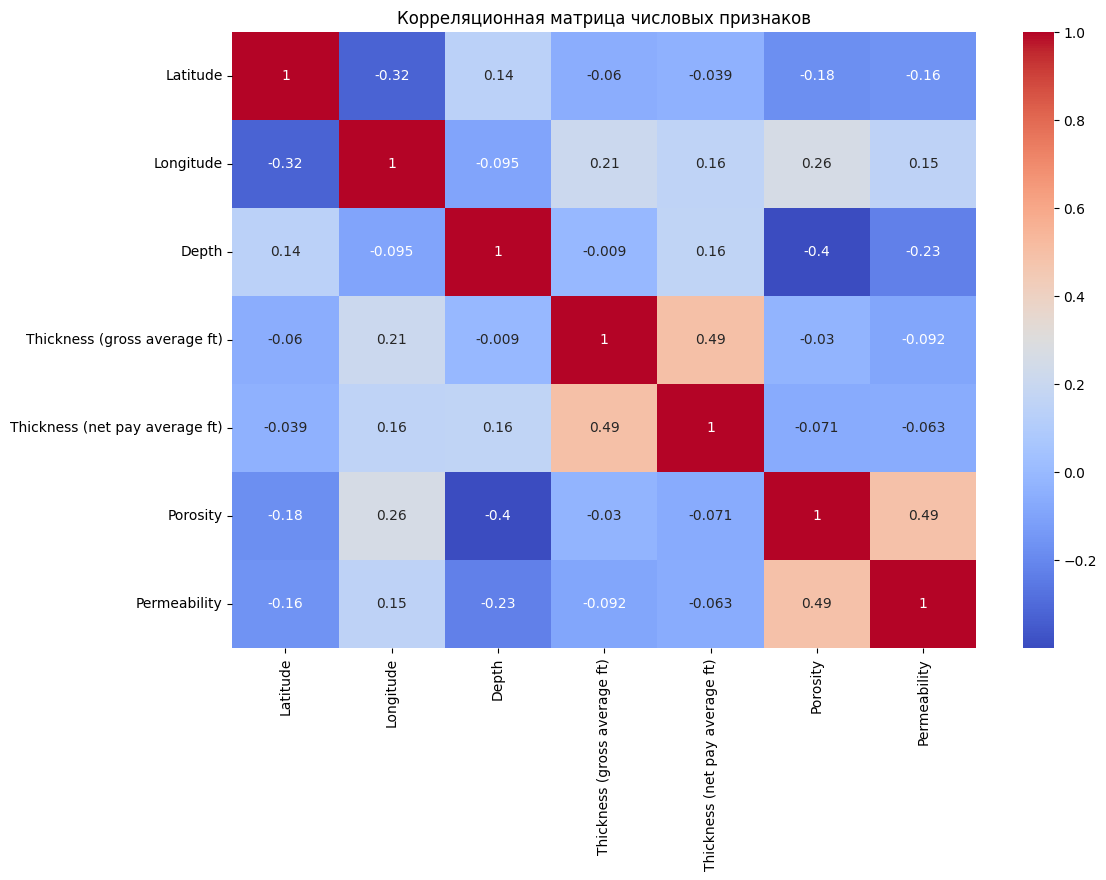

In [9]:
# Корреляция только по числовым колонкам
plt.figure(figsize=(12, 8))
sns.heatmap(train.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица числовых признаков')
plt.show()

## Исследование и обработка данных

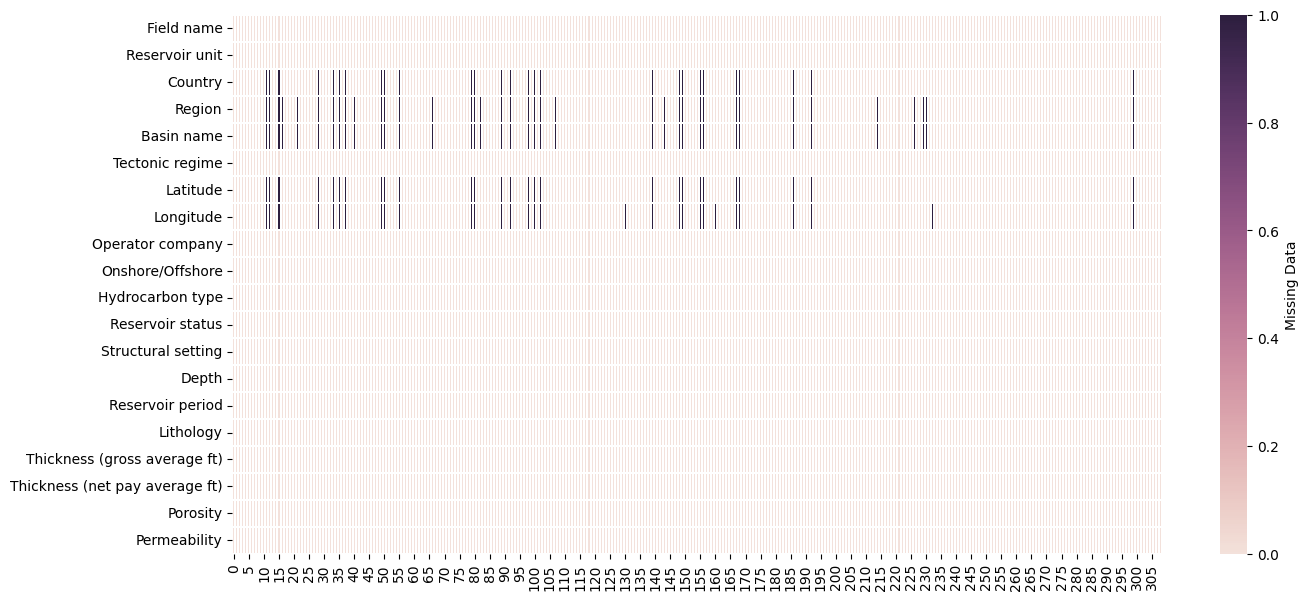

In [10]:
plt.figure(figsize=(15,7))

cmap = sns.cubehelix_palette(as_cmap=True, light=.9)

sns.heatmap(train.isna().transpose(), cmap=cmap,
            cbar_kws={'label': 'Missing Data'}, linewidths=0.05)

plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)

Я хочу заполнить пустые значения с помощью гео-библиотеки и широт и долгот

In [11]:
!pip install reverse_geocoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268067 sha256=0b7bb938ac70c37c0349a170ca417098accf9af7d9aefb1db9dd468bbbc6d451
  Stored in directory: /root/.cache/pip/wheels/17/3c/41/2bc89719586c2a5c53e9a527daa76a968a1288315c1ae2d904
Successfully built reverse_geocoder


In [12]:
import reverse_geocoder as rg

def guess_basin(row):
    if pd.isna(row['Basin name']) and pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
        try:
            result = rg.search((row['Latitude'], row['Longitude']))[0]
            return f"{result['admin1']} basin"  # например: "Texas basin"
        except:
            return row['Basin name']
    return row['Basin name']

train['Basin name'] = train.apply(guess_basin, axis=1)

Loading formatted geocoded file...


Проверяю, какой процент незаполненных значений остался

In [13]:
df_nan = train.loc[:, train.isnull().any()]
# процент пропущенных значений
df_nan.isnull().sum() / len(df_nan) * 100

,0
Country,8.737864
Region,12.297735
Basin name,8.737864
Latitude,8.737864
Longitude,9.708738


Проверяю, какое число строк осталось незаполненными

In [14]:
mask = train['Country'].notna() & train['Region'].isna()
print(mask.sum())

11


In [16]:
train[mask]['Country'].value_counts()

,count
Country,
USA,3
RUSSIA,2
UK,2
AUSTRALIA,1
INDIA,1
CHINA,1
INDONESIA,1


In [17]:
train[mask][['Country', 'Region', 'Latitude', 'Longitude']].head(10)

,Country,Region,Latitude,Longitude
16,INDIA,NaN,18.1720,72.3130
21,AUSTRALIA,NaN,-28.0000,140.0000
40,USA,NaN,31.5777,-102.9918
66,UK,NaN,53.3932,2.5239
82,RUSSIA,NaN,63.6375,54.9269
107,CHINA,NaN,38.1000,90.8700
143,USA,NaN,36.2674,-120.3659
214,USA,NaN,31.7490,-102.4430
226,INDONESIA,NaN,1.2956,101.2304
229,RUSSIA,NaN,66.0533,76.9497


In [18]:
from geopy.geocoders import Nominatim
import time

# Создаем геокодер
geolocator = Nominatim(user_agent="region_filler")

def fill_region_from_coords(row):
    if pd.isna(row['Region']) and pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
        try:
            location = geolocator.reverse((row['Latitude'], row['Longitude']), language='en')
            if location and location.raw.get('address'):
                return location.raw['address'].get('state', None)
        except Exception as e:
            print(f"Ошибка для {row['Latitude']}, {row['Longitude']}: {e}")
        time.sleep(1)  # пауза для защиты от блокировки API
    return row['Region']  # если уже есть — вернуть без изменений

# Применяем
train['Region'] = train.apply(fill_region_from_coords, axis=1)

2025-04-21 16:14:13,201 WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /reverse?lat=38.1&lon=90.87&format=json&accept-language=en&addressdetails=1
2025-04-21 16:14:13,201 WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /reverse?lat=38.1&lon=90.87&format=json&accept-language=en&addressdetails=1
2025-04-21 16:14:15,193 WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /reverse?lat=36.2674&lon=-120.3659&format=json&accept-language=en

In [19]:
# Посмотрим, остались ли незаполненные регионы
print("Осталось пропущенных Region:", train['Region'].isna().sum())

# Проверим несколько строк
train.loc[[16, 21, 40, 66, 82, 107, 143, 214, 226, 229], ['Country', 'Region', 'Latitude', 'Longitude']]

Осталось пропущенных Region: 30


,Country,Region,Latitude,Longitude
16,INDIA,NaN,18.1720,72.3130
21,AUSTRALIA,South Australia,-28.0000,140.0000
40,USA,Texas,31.5777,-102.9918
66,UK,NaN,53.3932,2.5239
82,RUSSIA,Komi Republic,63.6375,54.9269
107,CHINA,Qinghai,38.1000,90.8700
143,USA,California,36.2674,-120.3659
214,USA,Texas,31.7490,-102.4430
226,INDONESIA,Riau,1.2956,101.2304
229,RUSSIA,Yamalo-Nenets Autonomous Okrug,66.0533,76.9497


In [20]:
mask = train['Country'].notna() & train['Region'].isna()

In [21]:
# только 3 значения незаполнены
train[mask]['Country'].value_counts()

,count
Country,
UK,2
INDIA,1


In [22]:
# Удаляю незаполненные значения, так как их мало
train.drop(index=train[mask].index, inplace=True)

In [27]:
print("Осталось строк с заполненной Country и пустой Region:",
      ((train['Country'].notna()) & (train['Region'].isna())).sum())

Осталось строк с заполненной Country и пустой Region: 0


In [ ]:
# plt.figure(figsize=(15,7))

# cmap = sns.cubehelix_palette(as_cmap=True, light=.9)

# sns.heatmap(train.isna().transpose(), cmap=cmap,
#             cbar_kws={'label': 'Missing Data'}, linewidths=0.05)

# plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python1.png", dpi=100)

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      306 non-null    object 
 1   Reservoir unit                  306 non-null    object 
 2   Country                         279 non-null    object 
 3   Region                          279 non-null    object 
 4   Basin name                      279 non-null    object 
 5   Tectonic regime                 306 non-null    object 
 6   Latitude                        279 non-null    float64
 7   Longitude                       276 non-null    float64
 8   Operator company                306 non-null    object 
 9   Onshore/Offshore                306 non-null    object 
 10  Hydrocarbon type                306 non-null    object 
 11  Reservoir status                306 non-null    object 
 12  Structural setting              306 non-n

In [30]:
print(train.shape)

(306, 20)


Построить график корреляции Посмотреть, какие переменные строковые Если есть пропуски, обработать, если есть категориальные переменные - кодировать если надо масштабировать - масштабировать

### Обработка категориальных признаков

Проверяю и удаляю строки с большим числом пропусков

In [36]:
train = train[train[['Country', 'Region', 'Latitude', 'Longitude']].notna().all(axis=1)]

In [37]:
print(train.shape)

(276, 20)


In [38]:
train['Tectonic regime'].value_counts()

,count
Tectonic regime,
COMPRESSION,61
EXTENSION,26
COMPRESSION/EROSION,25
COMPRESSION/EVAPORITE,19
INVERSION/COMPRESSION/EXTENSION,18
EXTENSION/EROSION,12
GRAVITY/EXTENSION/EVAPORITE,10
INVERSION/COMPRESSION/EXTENSION/EROSION,7
GRAVITY/EXTENSION/EVAPORITE/SYNSEDIMENTATION,7


Как мы видим в колонке 'Tectonic regime' множество разных категорий, причем одному объекту может соответствовать несколько категорий сразу.

Встает вопрос как обработать такие признаки.

In [38]:
# Разбиваем колонку по разделителю '/' и делаем one-hot
tectonic_dummies = train['Tectonic regime'].str.get_dummies(sep='/')

# Добавляем префикс к именам колонок (для читаемости)
tectonic_dummies = tectonic_dummies.add_prefix('Tectonic regime_')

# Объединяем с исходным датафреймом
train = pd.concat([train.drop(columns='Tectonic regime'), tectonic_dummies], axis=1)

In [40]:
train['Structural setting'].value_counts()

,count
Structural setting,
FORELAND,69
RIFT,43
INTRACRATONIC,29
THRUST,15
PASSIVE MARGIN,12
SALT/FORELAND,11
SALT/PASSIVE MARGIN,9
INVERSION/BACKARC,7
INVERSION/RIFT,7


In [44]:
def multi_ohe(df, cols, sep='/'):
    df = df.copy()
    for col in cols:
        if col in df.columns:
            # Создаём dummies
            dummies = df[col].str.get_dummies(sep=sep).add_prefix(f'{col}_')

            # Удаляем исходную колонку
            df = df.drop(columns=[col])

            # Добавляем dummies
            df = pd.concat([df, dummies], axis=1)
    return df

In [45]:
train = multi_ohe(train, ['Tectonic regime', 'Structural setting'])

In [46]:
train.head()

,Field name,Reservoir unit,Country,Region,Basin name,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,...,Structural setting_FORELAND,Structural setting_INTRACRATONIC,Structural setting_INVERSION,Structural setting_PASSIVE MARGIN,Structural setting_RIFT,Structural setting_SALT,Structural setting_SUB-SALT,Structural setting_SUB-THRUST,Structural setting_THRUST,Structural setting_WRENCH
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,OIL,...,1,0,0,0,0,0,0,0,0,0
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,-19.6017,-39.8332,PETROBRAS,ONSHORE,OIL,...,0,0,0,1,0,0,0,0,0,0
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,...,1,0,0,0,0,0,0,0,0,0
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,61.3833,1.7500,CNR,OFFSHORE,OIL,...,0,0,0,0,1,0,0,0,0,0
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,53.2287,-115.8008,NUMEROUS,ONSHORE,OIL,...,1,0,0,0,0,0,0,0,0,0


In [47]:
train.columns

Index(['Field name', 'Reservoir unit', 'Country', 'Region', 'Basin name',
       'Latitude', 'Longitude', 'Operator company', 'Onshore/Offshore',
       'Hydrocarbon type', 'Reservoir status', 'Depth', 'Reservoir period',
       'Lithology', 'Thickness (gross average ft)',
       'Thickness (net pay average ft)', 'Porosity', 'Permeability',
       'Tectonic regime_BASEMENT-I', 'Tectonic regime_COMPRESSION',
       'Tectonic regime_DIAPIR', 'Tectonic regime_EROSION',
       'Tectonic regime_EVAPORITE', 'Tectonic regime_EXTENSION',
       'Tectonic regime_GRAVITY', 'Tectonic regime_INVERSION',
       'Tectonic regime_LINKED', 'Tectonic regime_REACTIVATION',
       'Tectonic regime_SHALE', 'Tectonic regime_STRIKE-SLIP',
       'Tectonic regime_SYNSEDIMENTATION', 'Tectonic regime_TRANSPRESSION',
       'Tectonic regime_TRANSTENSION', 'Tectonic regime_UPLIFT',
       'Structural setting_BACKARC', 'Structural setting_DELTA',
       'Structural setting_FOREARC', 'Structural setting_FORELAND',

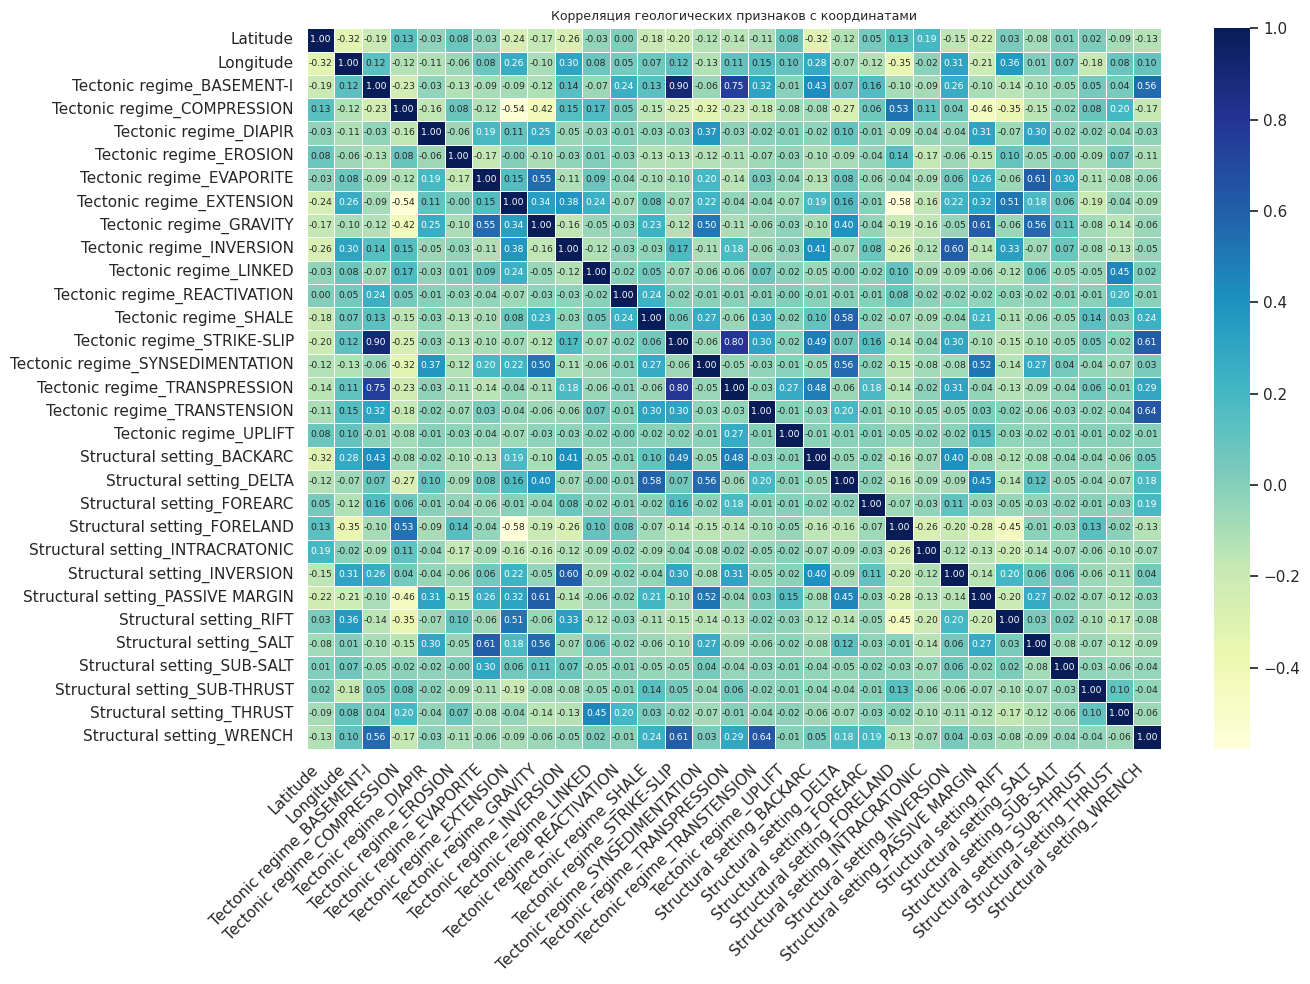

In [51]:
# Выбираем признаки, которые хотим проверить на корреляцию с координатами
geo_features = ['Latitude', 'Longitude']
tectonic_and_structural = [col for col in train.columns if col.startswith('Tectonic regime_') or col.startswith('Structural setting_')]

# Формируем подтаблицу
corr_df = train[geo_features + tectonic_and_structural]

# Вычисляем корреляцию
corr_matrix = corr_df.corr()

# Строим корреляционную матрицу
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    linewidths=0.5,
    linecolor='white',
    annot_kws={"size": 6.7}
)

plt.title("Корреляция геологических признаков с координатами", fontsize=9)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Некоторые геологические признаки часто встречаются вместе, например:

Tectonic regime_EVAPORITE и GRAVITY — высокая корреляция

TRANSPRESSION и STRIKE-SLIP — высокая корреляция

Это может говорить о совместной тектонической природе процессов.

In [54]:
cols_to_drop = [
    'Tectonic regime_DIAPIR', 'Tectonic regime_EROSION',
    'Tectonic regime_LINKED', 'Tectonic regime_REACTIVATION',
    'Tectonic regime_SHALE', 'Tectonic regime_TRANSTENSION',
    'Tectonic regime_UPLIFT', 'Structural setting_DELTA',
    'Structural setting_FOREARC', 'Structural setting_FORELAND',
    'Structural setting_INTRACRATONIC', 'Structural setting_RIFT',
    'Structural setting_SUB-SALT', 'Structural setting_SUB-THRUST',
    'Structural setting_THRUST'
]

train = train.drop(columns=cols_to_drop, errors='ignore')

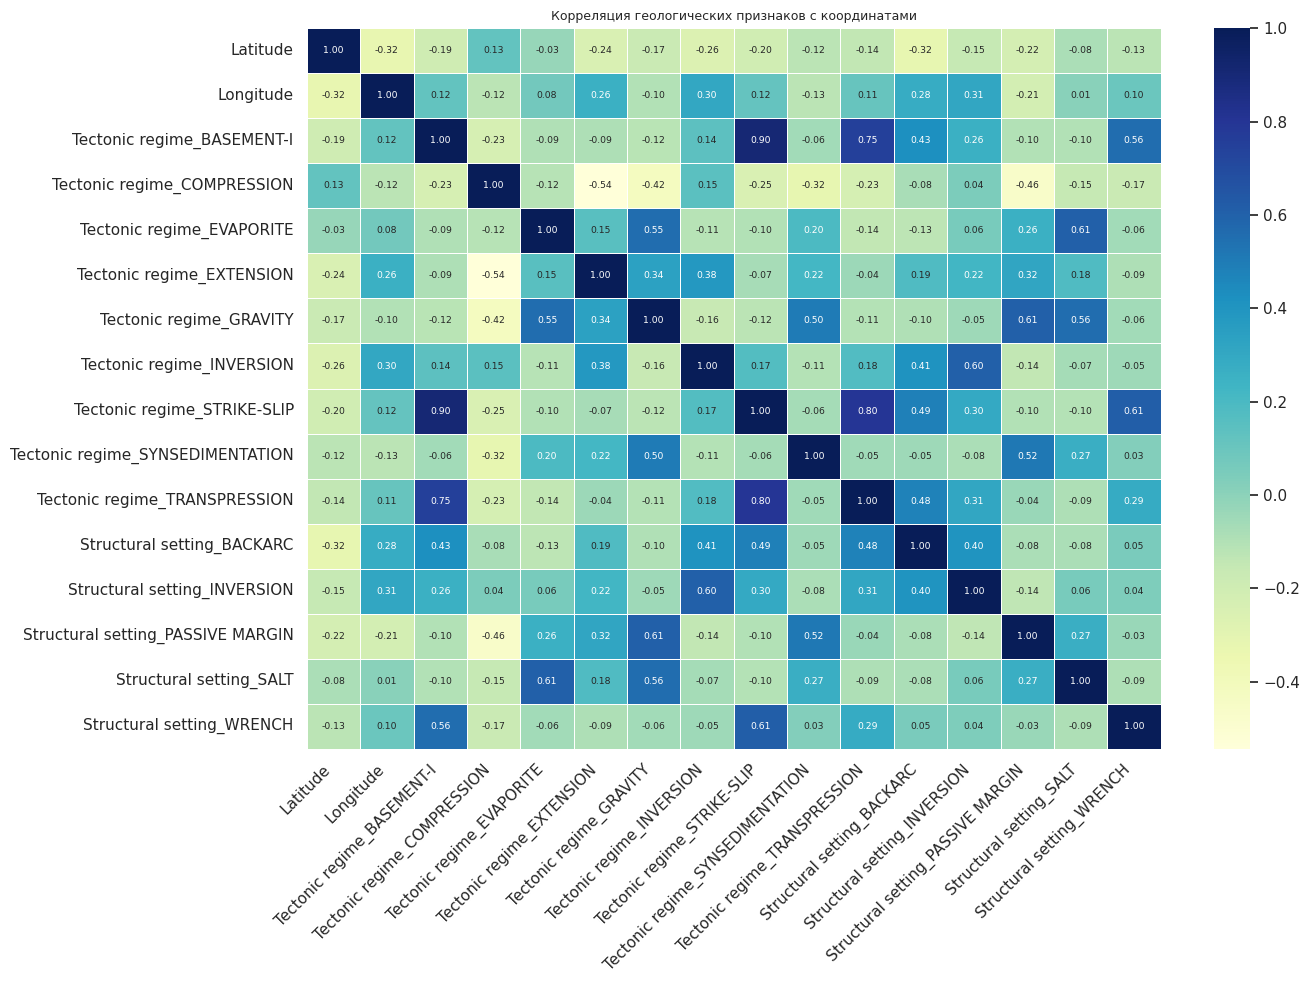

In [56]:
# Выбираем признаки, которые хотим проверить на корреляцию с координатами
geo_features = ['Latitude', 'Longitude']
tectonic_and_structural = [col for col in train.columns if col.startswith('Tectonic regime_') or col.startswith('Structural setting_')]

# Формируем подтаблицу
corr_df = train[geo_features + tectonic_and_structural]

# Вычисляем корреляцию
corr_matrix = corr_df.corr()

# Строим корреляционную матрицу
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    linewidths=0.5,
    linecolor='white',
    annot_kws={"size": 6.7}
)

plt.title("Корреляция геологических признаков с координатами", fontsize=9)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

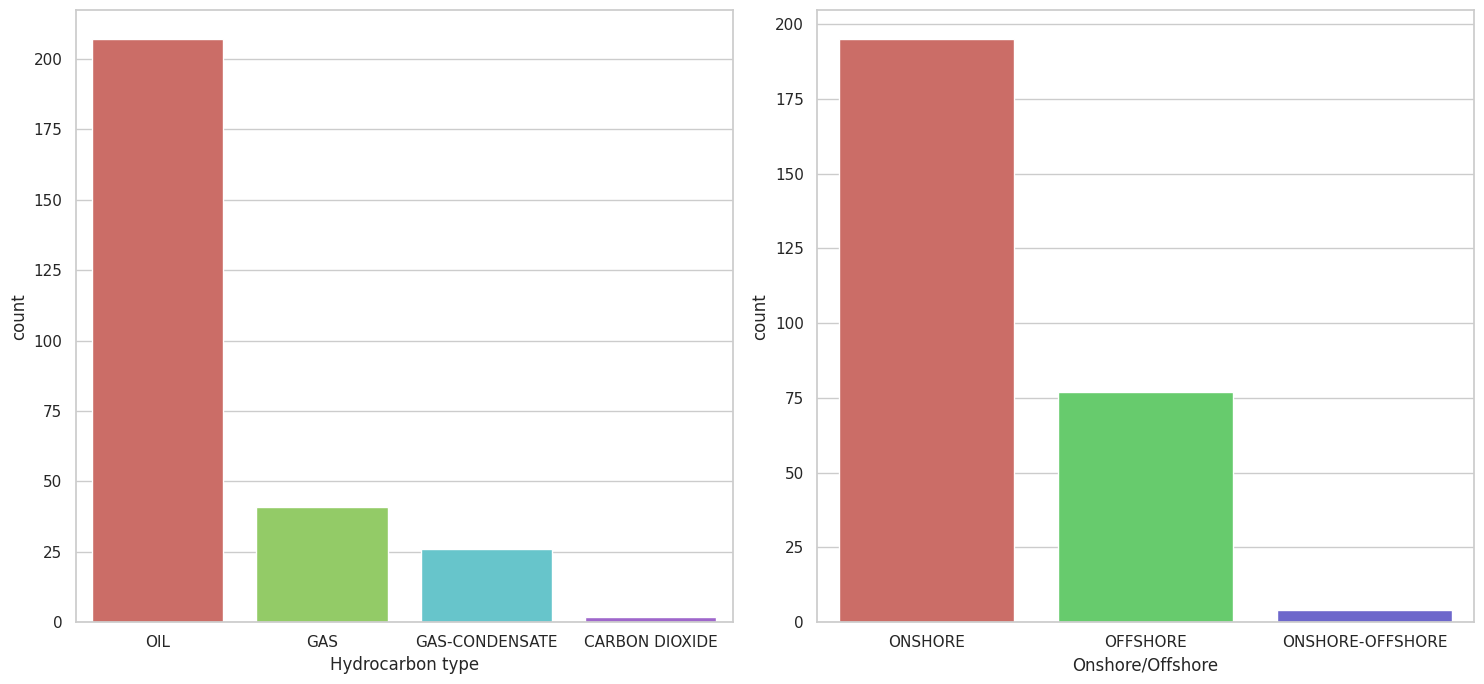

In [57]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

fig, ax = plt.subplots(1,2, figsize=(15, 7))

sns.countplot(x='Hydrocarbon type', data=train, hue='Hydrocarbon type', ax=ax[0], palette='hls', legend=False)
sns.countplot(x='Onshore/Offshore', data=train, hue='Onshore/Offshore', ax=ax[1], palette='hls', legend=False)

plt.tight_layout()
plt.show()

In [58]:
train['Onshore/Offshore'].value_counts()

,count
Onshore/Offshore,
ONSHORE,195
OFFSHORE,77
ONSHORE-OFFSHORE,4


In [72]:
# Создаём целевую переменную и признаки
X = train.drop(columns=['Onshore/Offshore'])
y = train['Onshore/Offshore']

# Кодируем целевую переменную

le = LabelEncoder()
train['Onshore/Offshore'] = le.fit_transform(train['Onshore/Offshore'])

# Проверим соответствие:
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'OFFSHORE': np.int64(0), 'ONSHORE': np.int64(1), 'ONSHORE-OFFSHORE': np.int64(2)}


<ipython-input-73-8a0edf588ad5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_numeric, palette='Set3')


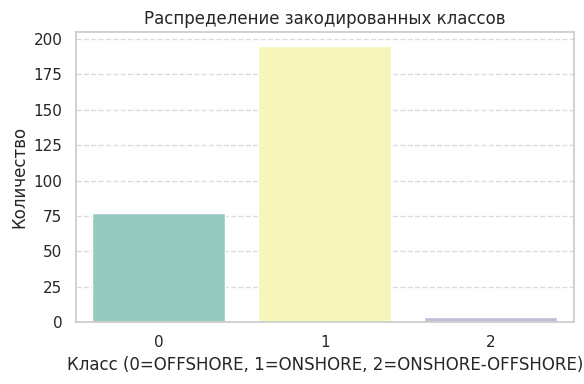

In [73]:
y_numeric = pd.Series(y_encoded, name='Encoded target')

# Визуализация
plt.figure(figsize=(6, 4))
sns.countplot(x=y_numeric, palette='Set3')
plt.title('Распределение закодированных классов')
plt.xlabel('Класс (0=OFFSHORE, 1=ONSHORE, 2=ONSHORE-OFFSHORE)')
plt.ylabel('Количество')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [74]:
print(type(y_encoded))
print(pd.Series(y_encoded).dtype)
print(np.unique(y_encoded))

<class 'numpy.ndarray'>
int64
[0 1 2]


In [85]:
!pip install -U imbalanced-learn

In [89]:
# Применяю SMOTE к дисбалансной выборке

from imblearn.over_sampling import SMOTE
from collections import Counter

# SMOTE требует X и y
smote = SMOTE(random_state=42, k_neighbors=2)

# X —  признаки (без целевой переменной)
# y — целевая переменная (в виде чисел 0/1/2)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Проверим распределение после SMOTE
print(Counter(y_resampled))

Counter({'ONSHORE': 195, 'OFFSHORE': 195, 'ONSHORE-OFFSHORE': 195})


Остальные категориальные признаки устроены проще и к ним можно применить обычные методы кодирования, которые мы изучали до этого.

Применим к ним кодировщик LabelEncoder().

In [91]:
from sklearn.preprocessing import OrdinalEncoder

# Список категориальных столбцов, которые нужно закодировать
categ = ['Hydrocarbon type', 'Reservoir status', 'Reservoir period', 'Lithology', 'Tectonic regime', 'Structural setting', 'Field name', 'Reservoir unit', 'Country', 'Region', 'Basin name', 'Operator company']

# Удалим из списка категориальных переменных те, которых уже нет в датафрейме
categ_actual = [col for col in categ if col in train.columns]

# Теперь безопасно применяем OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_encoded = encoder.fit_transform(train[categ_actual])
test_encoded = encoder.transform(test[categ_actual])

train[categ_actual] = train_encoded
test.loc[:, categ_actual] = test_encoded

In [92]:
train

,Field name,Reservoir unit,Country,Region,Basin name,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,...,Tectonic regime_GRAVITY,Tectonic regime_INVERSION,Tectonic regime_STRIKE-SLIP,Tectonic regime_SYNSEDIMENTATION,Tectonic regime_TRANSPRESSION,Structural setting_BACKARC,Structural setting_INVERSION,Structural setting_PASSIVE MARGIN,Structural setting_SALT,Structural setting_WRENCH
0,257.0,124.0,26.0,4.0,91.0,51.0000,44.8042,69.0,1,3.0,...,0,0,0,0,0,0,0,0,0,0
1,124.0,100.0,3.0,6.0,21.0,-19.6017,-39.8332,81.0,1,3.0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,14.0,27.0,7.0,85.0,26.0800,49.8100,95.0,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,153.0,34.0,37.0,2.0,52.0,61.3833,1.7500,31.0,0,3.0,...,0,0,0,0,0,0,0,0,0,0
4,239.0,137.0,4.0,8.0,93.0,53.2287,-115.8008,71.0,1,3.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,97.0,84.0,24.0,3.0,57.0,-6.0136,142.8409,73.0,1,2.0,...,0,0,0,0,0,0,0,0,0,0
305,59.0,59.0,4.0,8.0,81.0,76.4462,-108.9172,76.0,1,1.0,...,0,0,0,0,0,0,0,0,0,0
306,5.0,71.0,38.0,8.0,89.0,40.3000,-110.2100,71.0,1,3.0,...,0,0,0,0,0,0,0,0,0,0
307,23.0,133.0,38.0,8.0,63.0,45.1039,-105.0967,93.0,1,3.0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
test

,Field name,Reservoir unit,Country,Region,Basin name,Latitude,Longitude,Operator company,Hydrocarbon type,Reservoir status,...,Tectonic regime_GRAVITY,Tectonic regime_INVERSION,Tectonic regime_STRIKE-SLIP,Tectonic regime_SYNSEDIMENTATION,Tectonic regime_TRANSPRESSION,Structural setting_BACKARC,Structural setting_INVERSION,Structural setting_PASSIVE MARGIN,Structural setting_SALT,Structural setting_WRENCH
0,-1.0,19.0,8.0,0.0,0.0,29.7422,28.4925,48.0,2.0,5.0,...,0,0,0,0,0,False,0,False,0,False
1,1.0,-1.0,8.0,0.0,49.0,31.4382,31.3616,54.0,1.0,2.0,...,0,0,0,0,0,False,0,False,0,False
2,4.0,-1.0,16.0,4.0,14.0,48.4740,57.6667,58.0,3.0,4.0,...,0,0,0,0,0,False,0,False,0,False
3,6.0,-1.0,36.0,2.0,52.0,60.7833,1.7333,112.0,3.0,6.0,...,0,0,0,0,0,False,0,False,0,False
4,-1.0,-1.0,12.0,3.0,11.0,21.6000,72.9167,74.0,3.0,5.0,...,0,0,0,0,0,False,0,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,-1.0,-1.0,5.0,3.0,8.0,37.9167,118.4333,100.0,3.0,6.0,...,0,0,0,0,0,False,0,False,0,False
129,-1.0,-1.0,38.0,8.0,70.0,35.0461,-119.1904,-1.0,3.0,6.0,...,0,0,0,0,0,False,0,False,0,False
130,256.0,-1.0,5.0,3.0,8.0,38.2100,117.0600,82.0,3.0,5.0,...,0,0,0,0,0,False,0,False,0,False
131,256.0,-1.0,5.0,3.0,8.0,38.2100,117.0600,82.0,3.0,2.0,...,0,0,0,0,0,False,0,False,0,False


Heatmap позволяет визуадизировать матрицу корреляции между данными.

Корреляция - важнейший фактор, лежащий в основе анализа данных. Он сообщает, как переменные в наборе данных связаны друг с другом и как они перемещаются относительно друг друга. Значение корреляции колеблется от -1 до +1. 0 Корреляция означает, что две переменные не зависят друг от друга. Положительная корреляция указывает на то, что переменные движутся в одном направлении, а отрицательная корреляция указывает на противоположное.

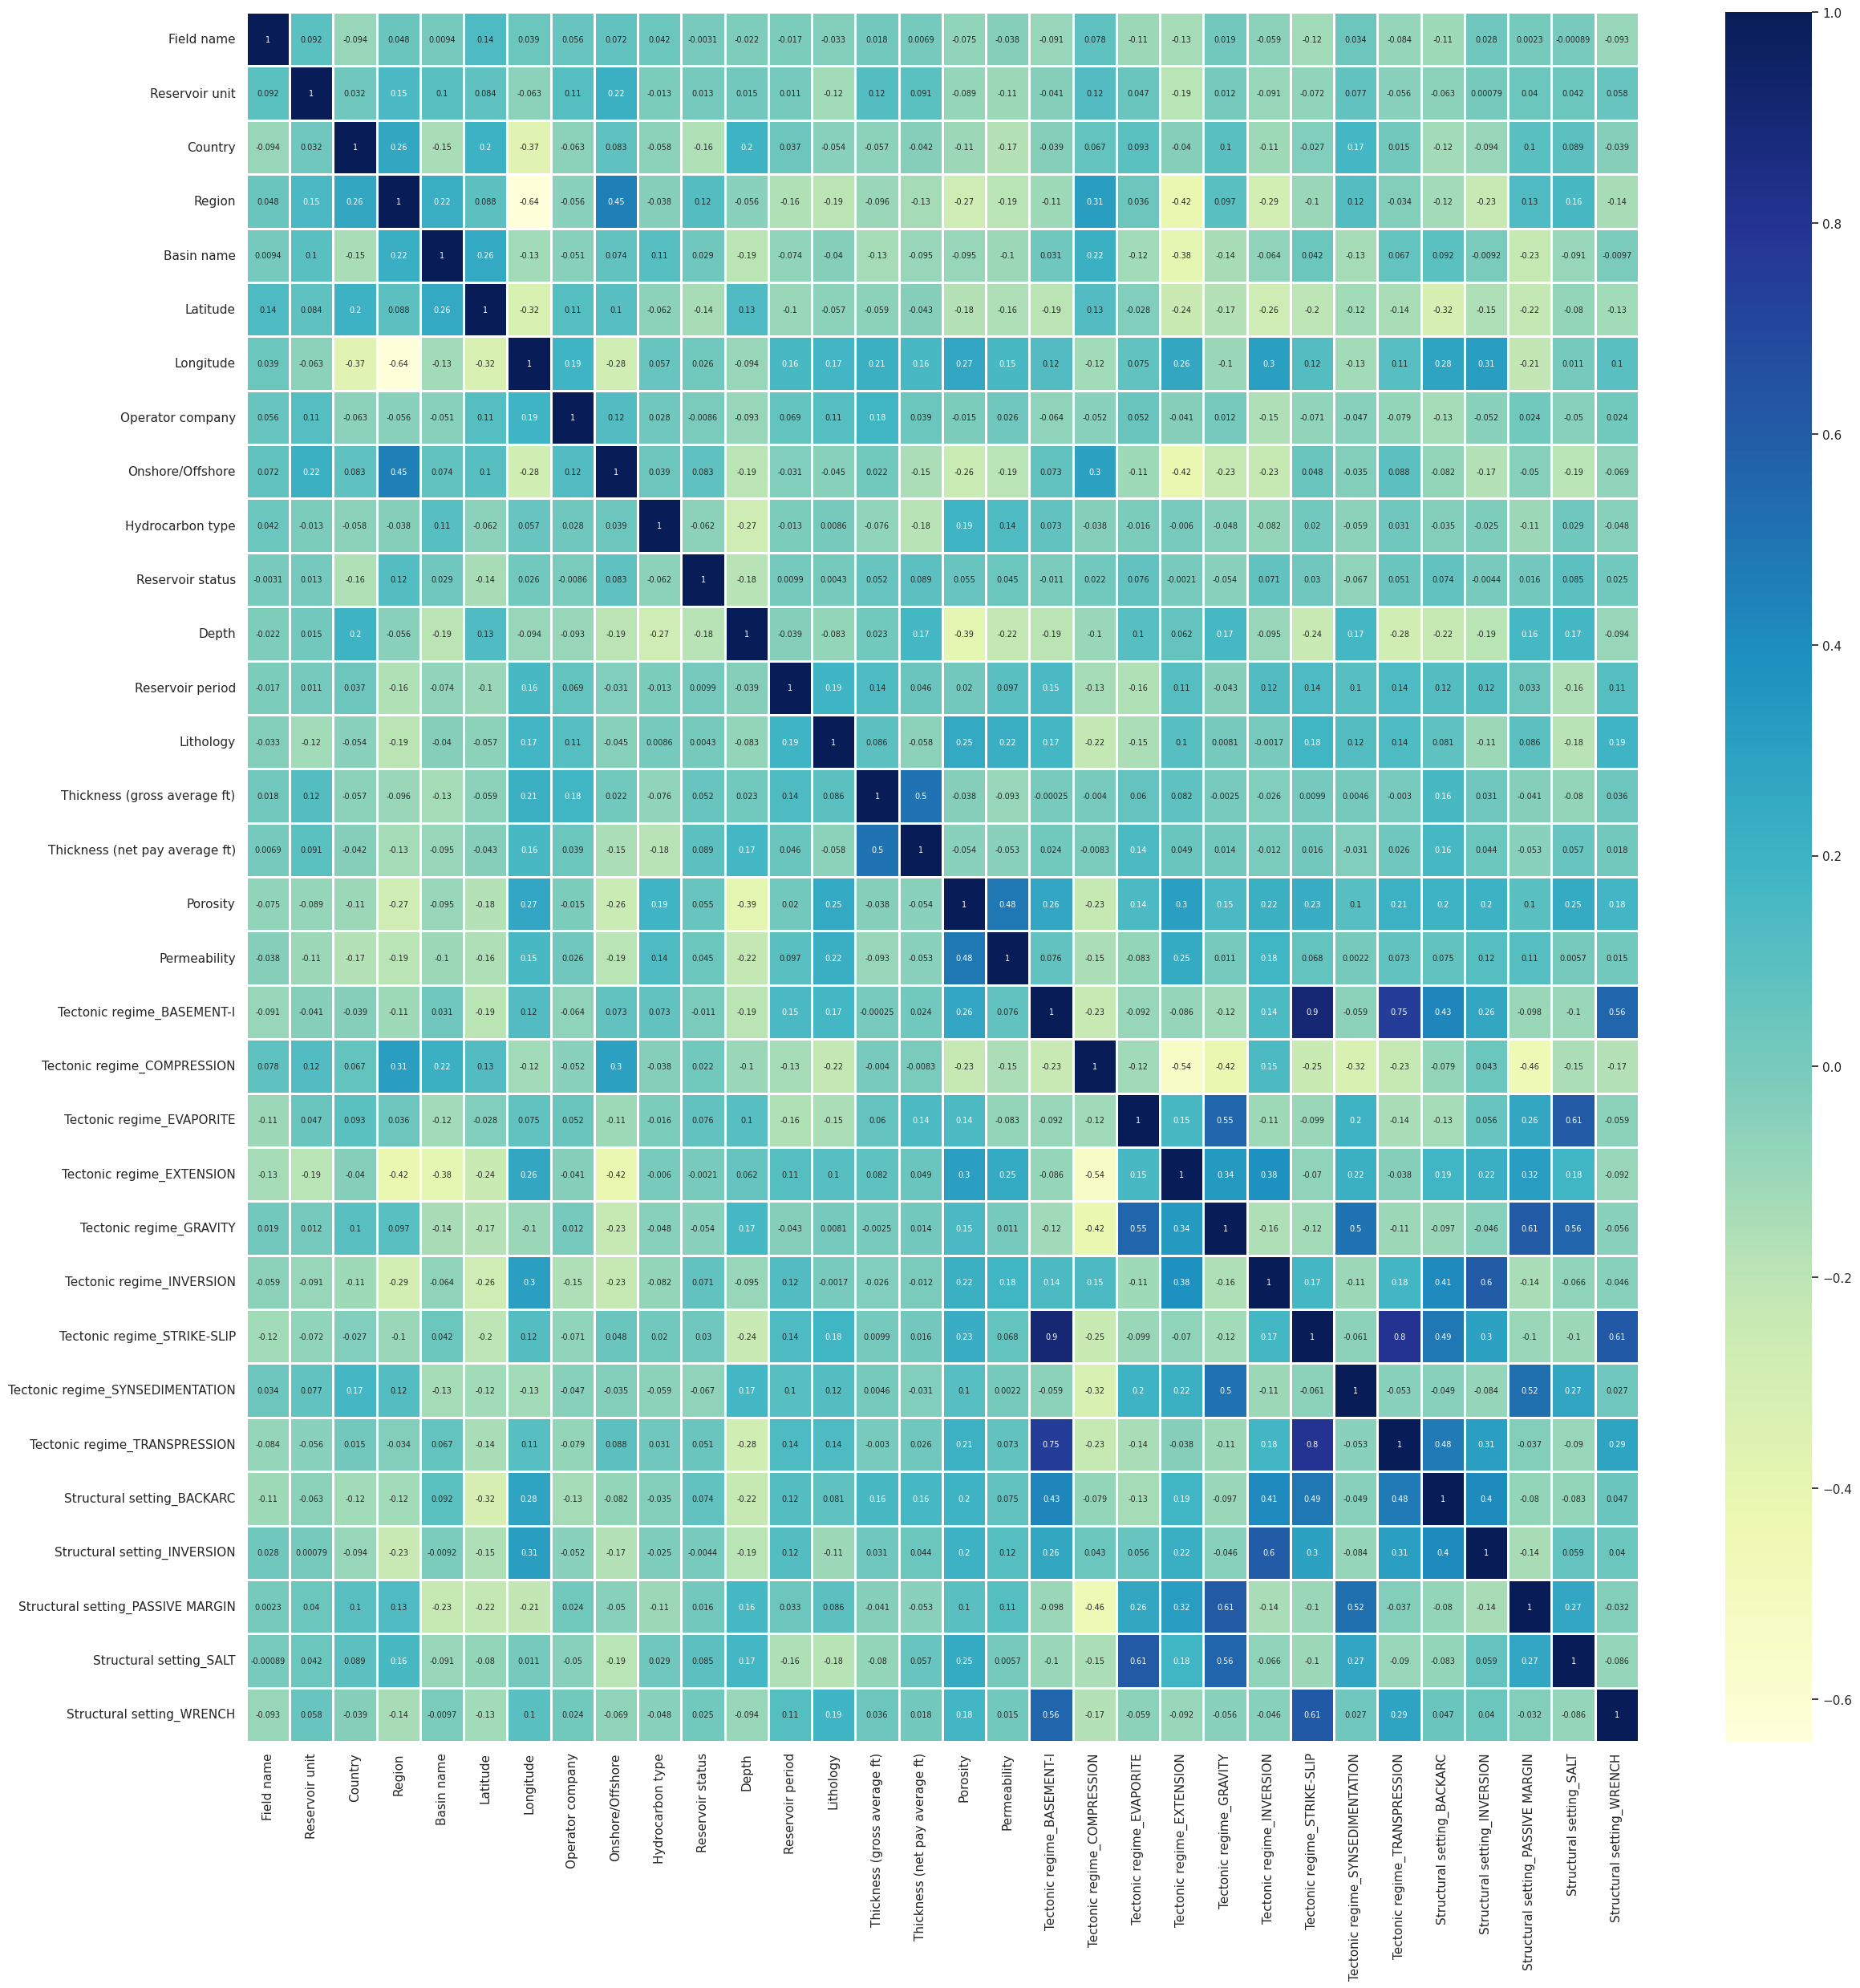

In [77]:
sns.set(rc={'figure.figsize': (28, 28)})

sns.heatmap(
    train.corr(),
    annot=True,
    annot_kws={"size": 7},
    cmap="YlGnBu",
    linecolor='white',
    linewidths=1
)

plt.savefig("heatmap.png")
plt.show()

По сути, это сетка цветных квадратов , где каждый квадрат, или bin , отмечает пересечение значений двух переменных, которые простираются вдоль горизонтальной и вертикальной осей.

Цветовые палитры: https://seaborn.pydata.org/tutorial/color_palettes.html

Информация о HeatMap: https://seaborn.pydata.org/generated/seaborn.heatmap.html


In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 0 to 308
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Field name                         276 non-null    float64
 1   Reservoir unit                     276 non-null    float64
 2   Country                            276 non-null    float64
 3   Region                             276 non-null    float64
 4   Basin name                         276 non-null    float64
 5   Latitude                           276 non-null    float64
 6   Longitude                          276 non-null    float64
 7   Operator company                   276 non-null    float64
 8   Onshore/Offshore                   276 non-null    int64  
 9   Hydrocarbon type                   276 non-null    float64
 10  Reservoir status                   276 non-null    float64
 11  Depth                              276 non-null    int64  
 12 

In [96]:
# Закодируем test так же, как train (с get_dummies)
expected_cols = train.drop(columns=['Onshore/Offshore'], errors='ignore').columns

# Добавим недостающие
for col in expected_cols:
    if col not in test.columns:
        test[col] = 0

# Упорядочим
test = test[expected_cols]

In [97]:
test.columns

Index(['Field name', 'Reservoir unit', 'Country', 'Region', 'Basin name',
       'Latitude', 'Longitude', 'Operator company', 'Hydrocarbon type',
       'Reservoir status', 'Depth', 'Reservoir period', 'Lithology',
       'Thickness (gross average ft)', 'Thickness (net pay average ft)',
       'Porosity', 'Permeability', 'Tectonic regime_BASEMENT-I',
       'Tectonic regime_COMPRESSION', 'Tectonic regime_EVAPORITE',
       'Tectonic regime_EXTENSION', 'Tectonic regime_GRAVITY',
       'Tectonic regime_INVERSION', 'Tectonic regime_STRIKE-SLIP',
       'Tectonic regime_SYNSEDIMENTATION', 'Tectonic regime_TRANSPRESSION',
       'Structural setting_BACKARC', 'Structural setting_INVERSION',
       'Structural setting_PASSIVE MARGIN', 'Structural setting_SALT',
       'Structural setting_WRENCH'],
      dtype='object')

In [98]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Field name                         133 non-null    float64
 1   Reservoir unit                     133 non-null    float64
 2   Country                            133 non-null    float64
 3   Region                             133 non-null    float64
 4   Basin name                         133 non-null    float64
 5   Latitude                           120 non-null    float64
 6   Longitude                          117 non-null    float64
 7   Operator company                   133 non-null    float64
 8   Hydrocarbon type                   133 non-null    float64
 9   Reservoir status                   133 non-null    float64
 10  Depth                              133 non-null    int64  
 11  Reservoir period                   133 non-null    float64

In [99]:
# Заменяем все булевы столбцы на int
bool_cols = test.select_dtypes(include='bool').columns
test[bool_cols] = test[bool_cols].astype(int)

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


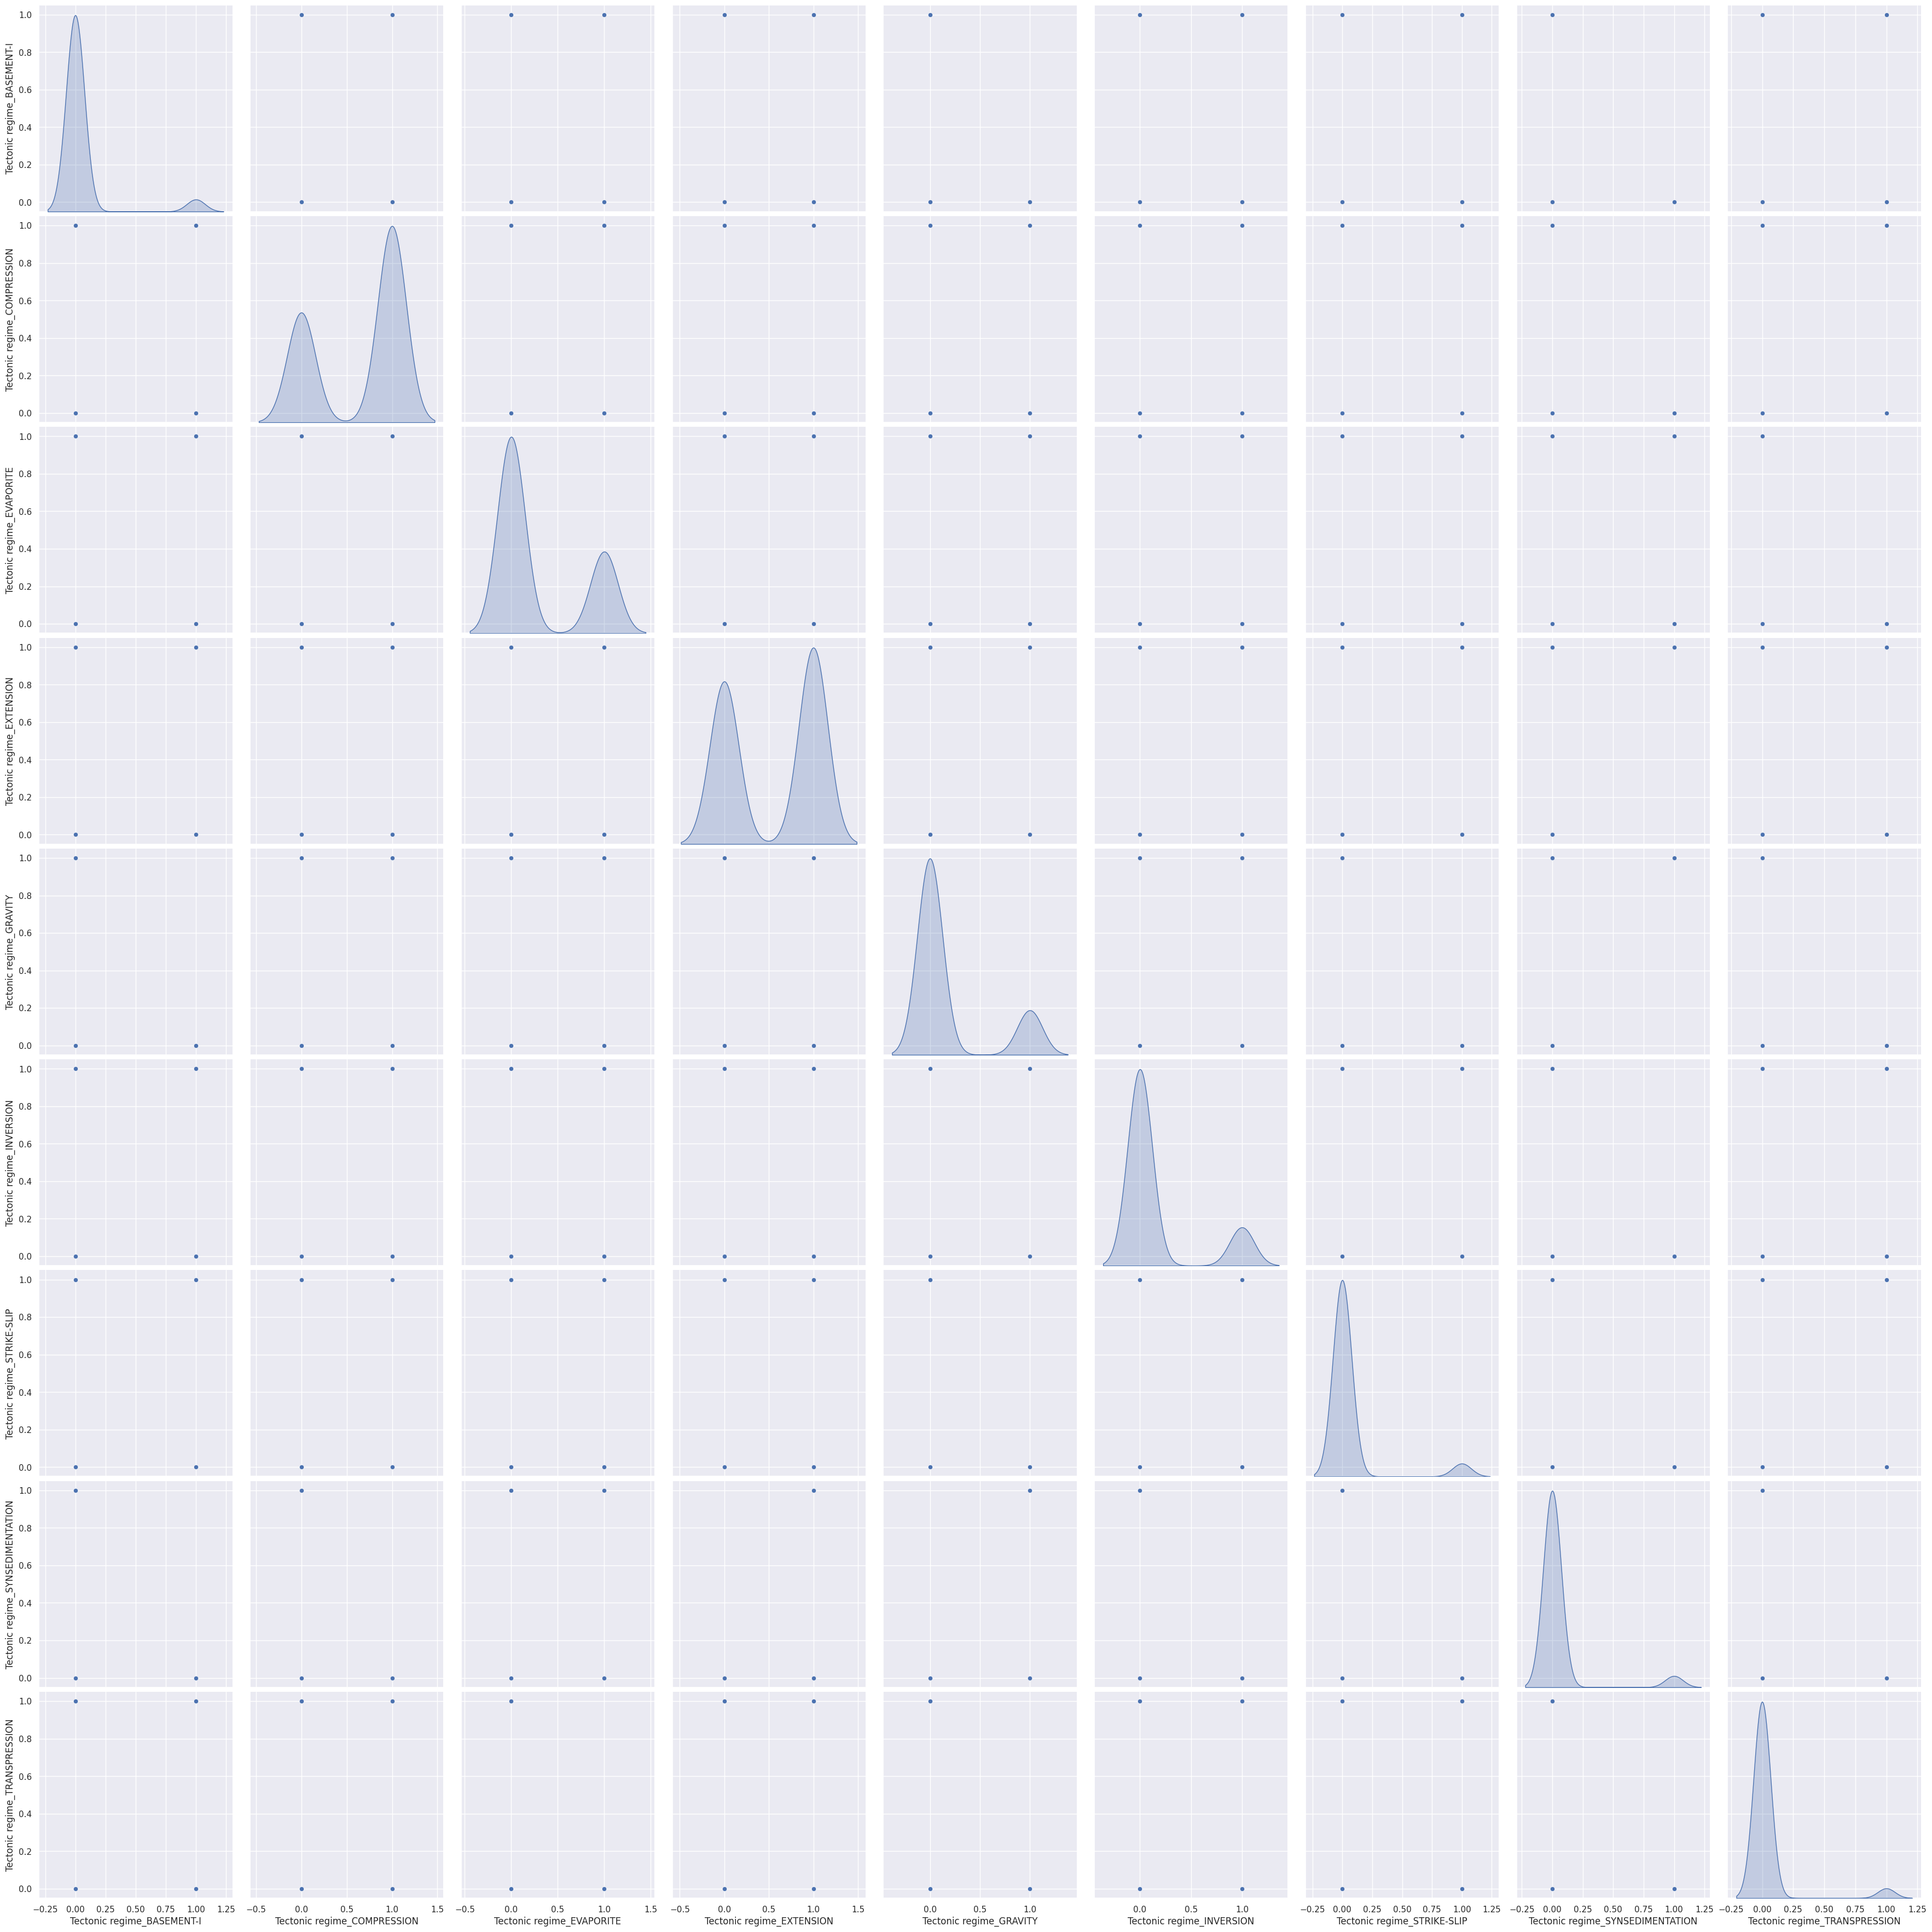

<Figure size 2800x2800 with 0 Axes>

In [100]:
sns.set()
columns = ['Tectonic regime_BASEMENT-I', 'Tectonic regime_COMPRESSION', 'Tectonic regime_EVAPORITE', 'Tectonic regime_EXTENSION', 'Tectonic regime_GRAVITY', 'Tectonic regime_INVERSION', 'Tectonic regime_STRIKE-SLIP', 'Tectonic regime_SYNSEDIMENTATION', 'Tectonic regime_TRANSPRESSION']

sns.pairplot(train[columns], size = 4, kind ='scatter', diag_kind='kde')
plt.show()

plt.savefig("pairplot.png")

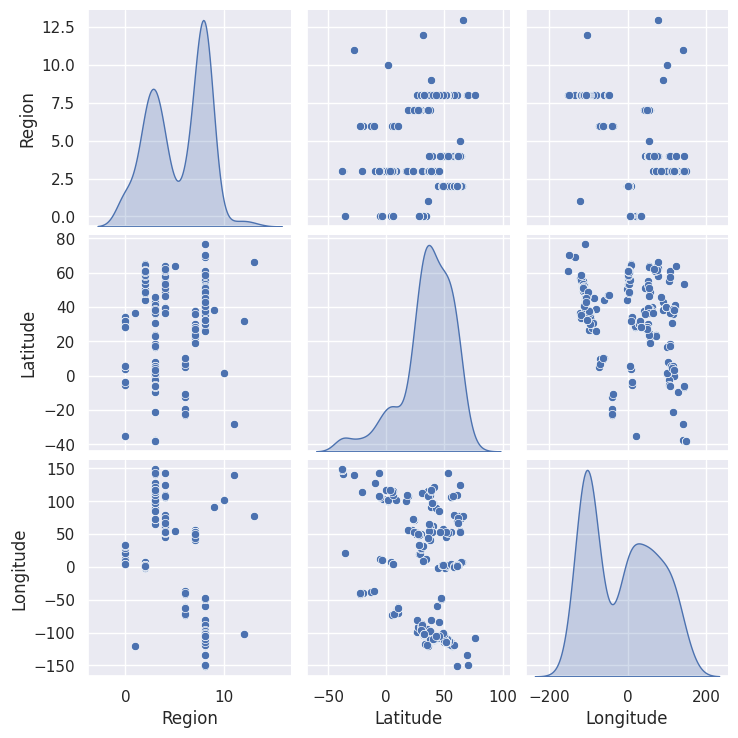

In [101]:
sns.set()
columns = ['Region', 'Latitude', 'Longitude']

sns.pairplot(train[columns], kind ='scatter', diag_kind='kde')
plt.show()

Посмотрим на баланс классов.

In [105]:
# Преобразуем обратно в DataFrame
import pandas as pd

X_res_df = pd.DataFrame(X_resampled, columns=X.columns)
y_res_df = pd.Series(y_resampled, name='Onshore/Offshore')

# Объединяем
train = pd.concat([X_res_df, y_res_df], axis=1)

<ipython-input-106-8c25235e347f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Onshore/Offshore', data=y_data, palette='hls')


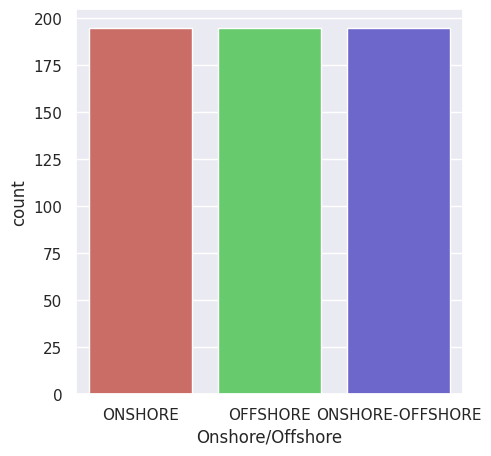

In [106]:
sns.set(rc = {'figure.figsize':(5,5)})
y_data = pd.DataFrame(train['Onshore/Offshore'])
sns.countplot(x='Onshore/Offshore', data=y_data, palette='hls')
plt.show()

In [107]:
train['Onshore/Offshore'].value_counts()

,count
Onshore/Offshore,
ONSHORE,195
OFFSHORE,195
ONSHORE-OFFSHORE,195


## Обучение модели

In [108]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=['Onshore/Offshore'])
y = train['Onshore/Offshore']

# Разбиваем данные с учетом стратификации
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,           # 20% данных в тест
    random_state=42,         # Фиксируем для воспроизводимости
    stratify=y               # Стратифицированное разбиение
)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (468, 31), (468,)
Train dataset size: (117, 31), (117,)


In [109]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Создадим модель дерева решений
tree = DecisionTreeClassifier()
knn = KNeighborsClassifier(2)

# обучение модели
tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

# предсказание ответов для тестовой выборки
y_pred_tree = tree.predict(X_test)
y_pred_knn = knn.predict(X_test)

In [110]:
y_test.value_counts()

,count
Onshore/Offshore,
ONSHORE,39
ONSHORE-OFFSHORE,39
OFFSHORE,39


In [111]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# answers_pred - ответы которые вернула модель для X_test
# y_test - это правильные ответы для X_test
print(f'Accuracy: {accuracy_score(y_test, y_pred_tree)}')
print(f'Accuracy: {accuracy_score(y_test, y_pred_knn)}')

Accuracy: 0.8461538461538461
Accuracy: 0.8290598290598291


In [112]:
import numpy as np

np.unique(y_train)

array(['OFFSHORE', 'ONSHORE', 'ONSHORE-OFFSHORE'], dtype=object)

In [113]:
len(set(X_train.columns) & set(X_test.columns)) == len(X_train.columns)

True

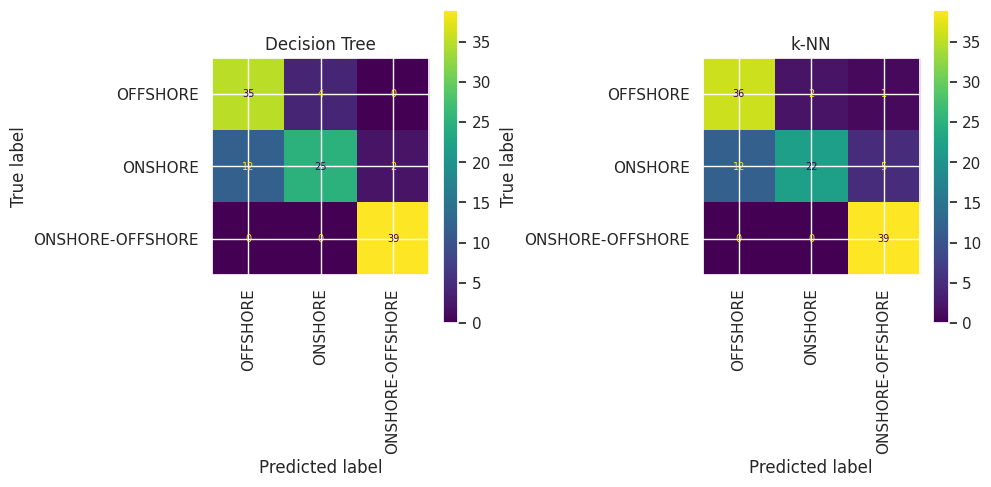

In [117]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

# Decision Tree
display_tree = ConfusionMatrixDisplay(conf_matrix_tree, display_labels=tree.classes_)
display_tree.plot(ax=axes[0], text_kw={'fontsize': 7})
axes[0].set_title('Decision Tree')
axes[0].tick_params(axis='x', rotation=90)

# k-NN
display_knn = ConfusionMatrixDisplay(conf_matrix_knn, display_labels=knn.classes_)
display_knn.plot(ax=axes[1], text_kw={'fontsize': 7})
axes[1].set_title('k-NN')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Вывод: knn работает гораздо лучше, но onshore предсказывают плохо. Пробуем другие методы.

In [118]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [123]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train_encoded)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train_encoded)
y_pred_xgb = xgb.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:38:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


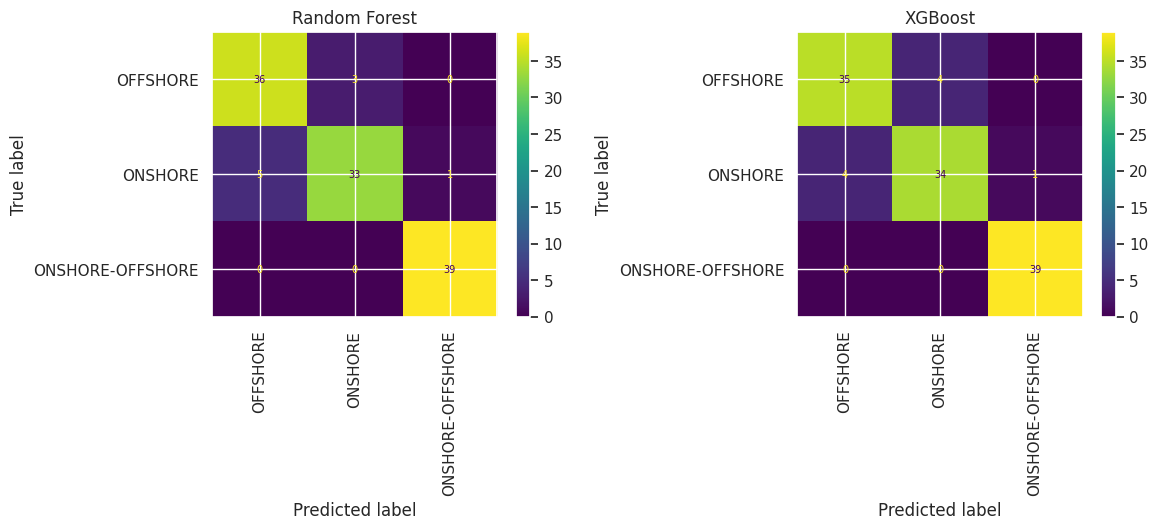

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# RF
ConfusionMatrixDisplay.from_predictions(
    y_test_encoded, y_pred_rf, display_labels=le.classes_,
    cmap='viridis', ax=axes[0], text_kw={'fontsize': 7}
)
axes[0].set_title('Random Forest')
axes[0].tick_params(axis='x', labelrotation=90)

# XGB
ConfusionMatrixDisplay.from_predictions(
    y_test_encoded, y_pred_xgb, display_labels=le.classes_,
    cmap='viridis', ax=axes[1], text_kw={'fontsize': 7}
)
axes[1].set_title('XGBoost')
axes[1].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

XGBoost даёт самые лучшие значения

In [139]:
from sklearn.preprocessing import LabelEncoder

# Предположим, y_test_pred содержит строковые метки:
# ['ONSHORE', 'OFFSHORE', 'ONSHORE-OFFSHORE', ...]

# Обучаем энкодер на всех возможных классах
le = LabelEncoder()
le.fit(['OFFSHORE', 'ONSHORE', 'ONSHORE-OFFSHORE'])

# Преобразуем строки в числа
y_test_pred_encoded = le.transform(y_test_pred)

# Сохраняем предсказания в CSV
ans_df = pd.DataFrame({'Onshore/Offshore': y_test_pred_encoded})
ans_df.to_csv('submission.csv', index_label='index')

In [137]:
# Убедись, что y_test_pred содержит числа (0, 1, 2)
print(np.unique(y_test_pred))  # должно быть что-то вроде: [0 1 2]

# inverse_transform превращает 0/1/2 → 'OFFSHORE' / 'ONSHORE' / ...

# ЕСЛИ y_test_pred — это строки, то inverse_transform НЕ НУЖЕН
# просто создаем DataFrame напрямую:
ans_df = pd.DataFrame({'Onshore/Offshore': y_test_pred})
ans_df.to_csv('submission.csv', index_label='index')

['OFFSHORE' 'ONSHORE' 'ONSHORE-OFFSHORE']


In [126]:
y_test_pred = tree.predict(test)
ans_df = pd.DataFrame(y_test_pred, columns=['Onshore/Offshore '])

ans_df.reset_index(inplace=True)
ans_df.to_csv('submition.csv', index=False)

In [127]:
from sklearn.preprocessing import LabelEncoder

# Используй тот же объект, который применял для y_train
# Предположим, он у тебя называется `le`
y_test_encoded = le.transform(y_test)  # Преобразуем строки в числа
